In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

import glob
from sklearn.linear_model import LinearRegression
import cv2

In [2]:
def norm_gau(data_refl):
    data_refl_norm = (data_refl - data_refl.mean())/data_refl.std()
    data_refl_norm = data_refl_norm*128 + 128
    data_refl_norm = np.where(data_refl_norm < 0, 0, data_refl_norm)
    data_refl_norm = np.where(data_refl_norm > 255, 255, data_refl_norm)
    return data_refl_norm.astype(np.uint8)

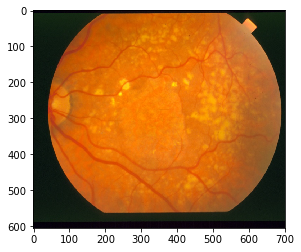

In [3]:
INPUT_DIR = './'

img = cv2.imread(INPUT_DIR + 'im0003.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
mask = cv2.imread(INPUT_DIR + 'im0003.labels.tif', 0)

plt.imshow(img)
plt.show()

## Homomorphic filtering

In [4]:
# Homomorphic filter class
class HomomorphicFilter:
    """Homomorphic filter implemented with diferents filters and an option to an external filter.
    
    High-frequency filters implemented:
        butterworth
        gaussian
    Attributes:
        a, b: Floats used on emphasis filter:
            H = a + b*H
        
        .
    """

    def __init__(self, a = 0.5, b = 1.5):
        self.a = float(a)
        self.b = float(b)

    # Filters
    def __butterworth_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
        return (1 - H)

    def __gaussian_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        H = np.zeros(I_shape)
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = np.exp((-Duv/(2*(filter_params[0])**2)))
        return (1 - H)

    # Methods
    def __apply_filter(self, I, H):
        H = np.fft.fftshift(H)
        I_filtered = (self.a + self.b*H)*I
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        """
        Method to apply homormophic filter on an image
        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency 
                    filter_params[1]: Order of filter
                gaussian:
                    filter_params[0]: Cutoff frequency
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

        #  Validating image
        if len(I.shape) is not 2:
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain 
        I_log = np.log1p(np.array(I, dtype="float"))
        I_fft = np.fft.fft2(I_log)

        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) is not 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')
        
        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.exp(np.real(I_filt))-1
        return np.uint8(I)
# End of class HomomorphicFilter

In [5]:
homo_filter = HomomorphicFilter(a = 0.75, b = 1.25)
img_filtered = homo_filter.filter(I=img[:,:,1], filter_params=[30,3])

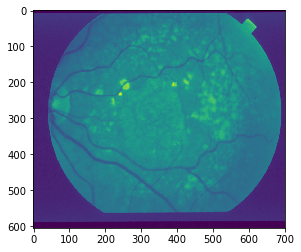

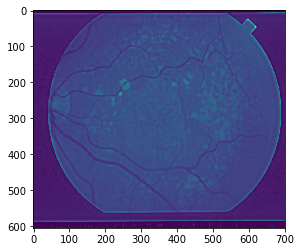

In [6]:
plt.imshow(img[:,:,1])
plt.show()

# img_filtered = img[:,:,1].copy()
plt.imshow(img_filtered)
plt.show()

## Gaussian filtering

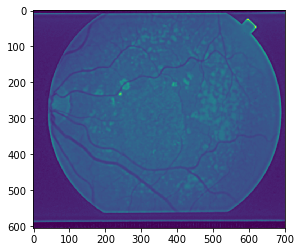

In [7]:
img_filtered_blur = cv2.GaussianBlur(img_filtered,(5,5),0)

plt.imshow(img_filtered_blur)
plt.show()

## Gradient of an image

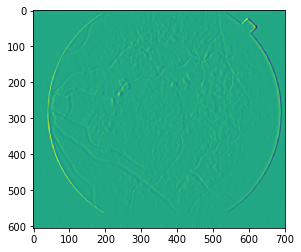

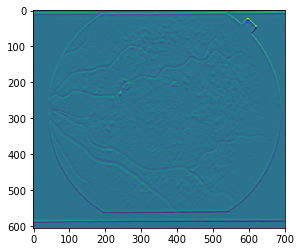

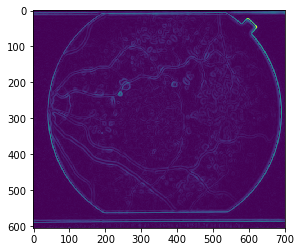

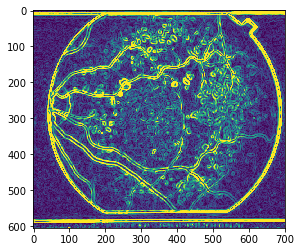

In [8]:
sobelx = cv2.Sobel(img_filtered_blur,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img_filtered_blur,cv2.CV_64F,0,1,ksize=5)

g_f = np.sqrt(sobelx**2 + sobely**2)


plt.imshow(sobelx)
plt.show()

plt.imshow(sobely)
plt.show()

plt.imshow(g_f)
plt.show()

plt.imshow(norm_gau(g_f))
plt.show()

# g_f = norm_gau(g_f)

## Non-maxima suppression

In [9]:
g_f_non = g_f.copy()
count = 0
for x in range(g_f.shape[1]):
    for y in range(g_f.shape[0]):
        if g_f[y,x] == 0:
            ## 8286
            continue
        if sobelx[y,x] == 0:
            if (g_f[y,x] > g_f[y-1,x]) and (g_f[y,x] > g_f[y+1,x]):
                # 1399
                continue
                
        if sobely[y,x] == 0:
            if (g_f[y,x] > g_f[y,x-1]) and (g_f[y,x] > g_f[y,x+1]): 
                # 1619
                continue

        phi = np.arctan(sobely[y,x]/sobelx[y,x])

        if (phi < np.pi/4 and phi > -np.pi/4):
            if (g_f[y,x] >= g_f[y,x-1]) and (g_f[y,x] >= g_f[y,x+1]): 
                # 42503
                continue
        else:
            if (g_f[y,x] >= g_f[y-1,x]) and (g_f[y,x] >= g_f[y+1,x]): 
                # 44973
                continue

        g_f_non[y,x] = 0
        # 324720

/home/quang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


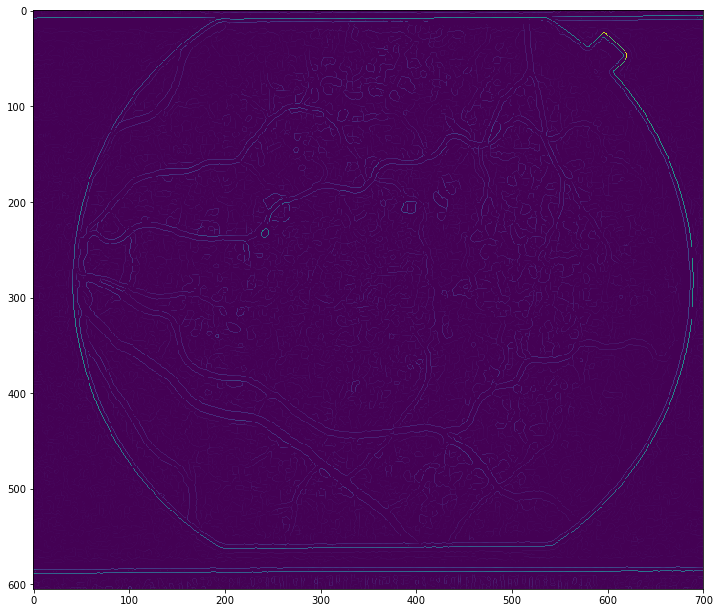

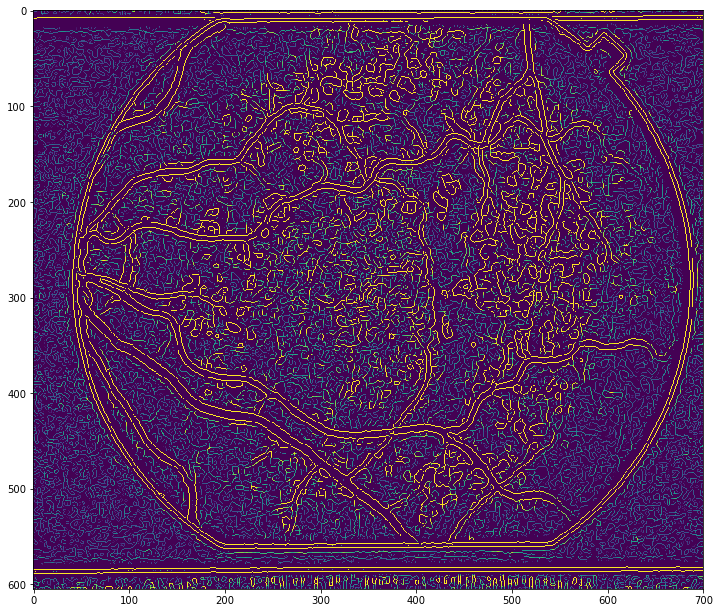

In [10]:
plt.figure(figsize=(12,12))

plt.imshow(g_f_non)
plt.show()
g_f_non_norm = norm_gau(g_f_non)
plt.figure(figsize=(12,12))
plt.imshow(g_f_non_norm)
plt.show()

## Gradient magnitude thresholding

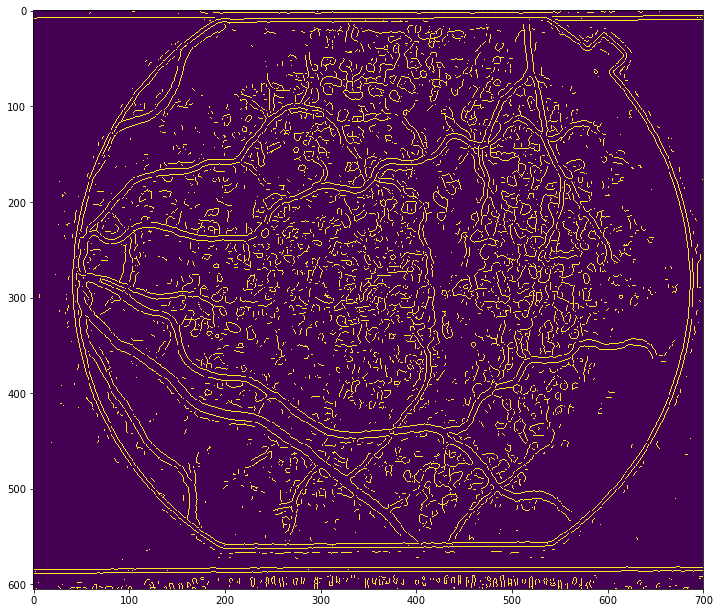

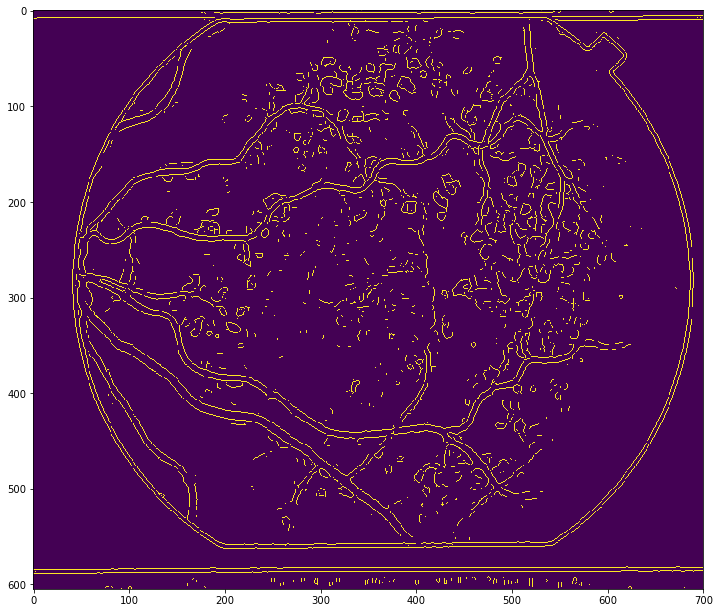

In [11]:
min_f = np.where(g_f_non > 120, 1, 0) 
plt.figure(figsize=(12,12))
plt.imshow(min_f)
plt.show()

max_f = np.where(g_f_non > 200, 1, 0)
plt.figure(figsize=(12,12))
plt.imshow(max_f)
plt.show()

## Edge tracking by hysteresis

In [12]:
# TO_DO
# edge_tracking = max_f.copy()
# for x in range(g_f.shape[1]):
#     for y in range(g_f.shape[0]):
#         if max_f[y-1:y+1,x-1:x+1].sum() > 0 and min_f[y,x] > 0:
#             edge_tracking[y,x] = 1
            
# plt.figure(figsize=(12,12))
# plt.imshow(edge_tracking)
# plt.show()

edge_tracking = max_f

## Iterative edge thinning

In [13]:
# TO_DO

## End point recovery

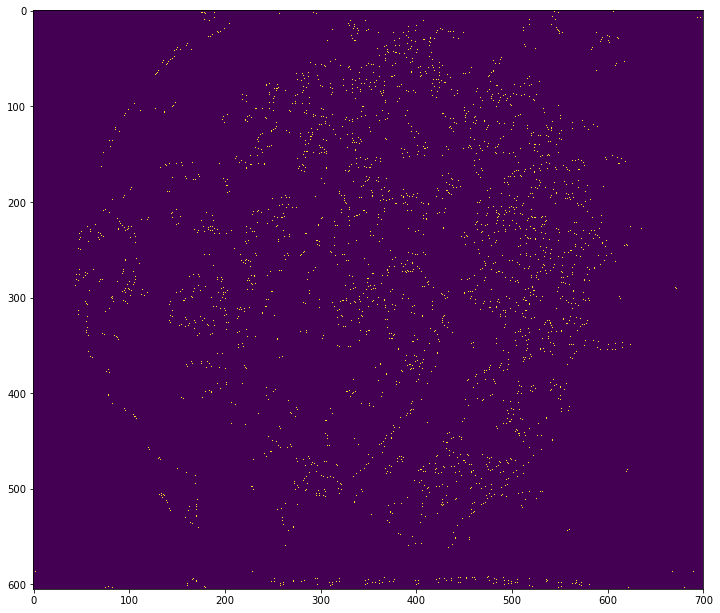

In [14]:
kernel_1 = np.array([[1, 1, 1],
                   [0, 1, 0],
                   [0, 0, 0]])

kernel_2 = np.array([[1, 0, 0],
                     [1, 1, 0],
                     [1, 0, 0]])

kernel_3 = np.array([[0, 0, 1],
                     [0, 1, 1],
                     [0, 0, 1]])

kernel_4 = np.array([[0, 0, 0],
                     [0, 1, 0],
                     [1, 1, 1]])

kernel_list = [kernel_1, kernel_2, kernel_3, kernel_4]
edge_tracking_1 = np.zeros(edge_tracking.shape)
for x in range(1, g_f.shape[1]-1):
    for y in range(1, g_f.shape[0]-1):
        if edge_tracking[y,x] == 0:
            continue
        temp1 = edge_tracking[y-1:y+2,x-1:x+2]
        for k in kernel_list:
            if not ((k == 0)*temp1).any() and (temp1==k).sum() > 1:
                edge_tracking_1[y,x] = 1
                continue

plt.figure(figsize=(12,12))
plt.imshow(edge_tracking_1)
plt.show()

## End point labeling

The endpoints of edges after recovery are labeled to minimize the incorrect linking decisions. A common label is assigned to
the group of pixels that have similar features and in this way a local edge structure is assessed. The gaps in unconnected edge
structures are bridged in agreement with the directionality of the endpoints.

In [15]:
# TO_DO_LATER

## Boundary detection by edge linking

In [16]:
# TO_DO_LATER